In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
#Setting up for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import pydot
import graphviz
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

tfku= tf.keras.utils
tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
#Pparamater setting
FILTER_SIZE = 128
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
#This projfect using 5-fold validation.
NFOLD = 5 
STEPS_PER_EPOCH = 200
MAX_MIXUP_LENGTH = 512
MIN_MIXUP_LENGTH = 64
MIXUP_ELEM_PROBA = 0.3
MIXUP_DO_PROBA = 0.4
MAX_CUTOUT_LENGTH = 512 
MIN_CUTOUT_LENGTH = 64
CUTOUT_ELEM_PROBA = 0.3
CUTOUT_DO_PROBA = 0.4
LINEAR_MIX_MIN = 0.1
LINEAR_MIX_MAX = 0.4
LINEAR_MIX_PROBA = 0.4
#The NGAFID-MC, including 2 different cluster, C37 and C28, for this project, we are using 37 only
ID = 37

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
#Drop duplicate value and see the split
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             318
      1             224
1     0             246
      1             171
2     0             323
      1             252
3     0             256
      1             162
4     0             270
      1             167

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
#Preprocesssing using MinMaxScaler
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 
  
    for id in tqdm(ids): 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)

    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
folded_datasets = []
#Get dataset base on the before and after maintanence action
for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 0/323 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

In [9]:
#Muiltiple data augumentaion method
def random_sliced(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

def random_shift(x, y):
    x = tf.pad(x, [[64, 64], [0,0]])    
    start = tf.random.uniform(shape=[], minval=0, maxval=64, dtype=tf.int64)
    x = x[start: start + SHAPE[0]]
    x = tf.reshape(x, (SHAPE[0], 23))
    return x, y

def batch_random_linear_mixup(x): 
    batch_size = BATCH_SIZE
    new = tf.random.uniform((), minval=LINEAR_MIX_MIN, maxval=LINEAR_MIX_MAX)
    prob = LINEAR_MIX_PROBA
    do_aug = tf.cast(tf.random.uniform((batch_size, 1, 1), minval=0.0, maxval=1.0) > prob, tf.float32) 

    take_from_b_percetnage = do_aug * new 

    a = x 
    b = tf.random.shuffle(x)

    x = a * (1-take_from_b_percetnage) + b* (take_from_b_percetnage)

    return x 

def get_batch_random_cutout(model_type):
    
    batch = BATCH_SIZE
    
    if model_type == 1:
        length = SHAPE[0]
    elif model_type == 2: 
        length = BLOCK_SHAPE[0]
        
    nvar = VARIABLES
    max_cutout_length = MAX_CUTOUT_LENGTH
    min_coutout_length = MIN_CUTOUT_LENGTH
    elem_drop_prob = CUTOUT_ELEM_PROBA
    do_prob = CUTOUT_DO_PROBA


    def time_wise_cut(nothing):
        time = tf.range(0, length, dtype=tf.float32)
        start = tf.random.uniform((), maxval=length - max_cutout_length)
        end = start + tf.random.uniform((),minval=min_coutout_length, maxval=max_cutout_length)
        do = tf.cast(tf.random.uniform((), ) < do_prob, tf.float32)     
        return tf.cast(tf.logical_and(time > start, time < end), tf.float32) * do


    def element_wise_cut(nothing):
        return tf.cast(tf.random.uniform((nvar,)) < elem_drop_prob, tf.float32) 

    def cutout_mask(nothing):

        time = tf.reshape(time_wise_cut(nothing), (length, 1)) 
        elem = tf.reshape(element_wise_cut(nothing), (1, nvar))
        return tf.cast(time * elem < 1, tf.float32)

    def batch_random_cutout(x):
        x = x * tf.map_fn(cutout_mask, tf.zeros((batch,) ), dtype=tf.float32)
        return x 
    return batch_random_cutout

def get_batch_cutmix(model_type): 
    batch = BATCH_SIZE
    
    if model_type == 1:
        length = SHAPE[0]
    elif model_type == 2:
        length = BLOCK_SHAPE[0]  
    nvar = VARIABLES
    max_cutout_length = MAX_MIXUP_LENGTH
    min_coutout_length = MIN_MIXUP_LENGTH
    elem_drop_prob = MIXUP_ELEM_PROBA
    do_prob = MIXUP_DO_PROBA


    def time_wise_cut(nothing):
        time = tf.range(0, length, dtype=tf.float32)
        start = tf.random.uniform((), maxval=length - max_cutout_length)
        end = start + tf.random.uniform((),minval=min_coutout_length, maxval=max_cutout_length)
        do = tf.cast(tf.random.uniform((), ) < do_prob, tf.float32)     
        return tf.cast(tf.logical_and(time > start, time < end), tf.float32) * do


    def element_wise_cut(nothing):
        return tf.cast(tf.random.uniform((nvar,)) < elem_drop_prob, tf.float32) 

    def cutout_mask(nothing):

        time = tf.reshape(time_wise_cut(nothing), (length, 1)) 
        elem = tf.reshape(element_wise_cut(nothing), (1, nvar))
        return tf.cast(time * elem < 1, tf.float32)

    def batch_cutmix(x):
        a = x 
        b = tf.random.shuffle(x)
        mask = tf.map_fn(cutout_mask, tf.zeros((batch,) )) > 0
        return tf.where(mask, a, b)

    return batch_cutmix

def get_batch_aug(model_type): 

    batch_random_cutout = get_batch_random_cutout(model_type)
    batch_cutmix = get_batch_cutmix(model_type)

    def batch_aug(x, y): 

        x = batch_cutmix(x)
        x = batch_random_cutout(x)
        x = batch_random_linear_mixup(x)
        return x, y
    
    return batch_aug

def fix_type(x, y):
    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [10]:
def prepare_for_training(ds, model_type, shuffle = False, repeat = False, predict= True):
    
    
    ds = ds.map(fix_type)
    if model_type == 1:
        ds = ds.map(random_shift)
    elif model_type == 2:
        ds = ds.map(random_sliced)
    
    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    batch_aug = get_batch_aug(model_type)
    ds = ds.map(batch_aug)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [11]:
def get_train_and_val_for_fold(folded_datasets, fold, model):
    predict = True
    
    train = []
    for i in range(NFOLD): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, model_type = model, shuffle=False, )
    train_ds = prepare_for_training(train_ds,model_type = model, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, model_type = model, shuffle=False)
    
    return train_ds, val_ds, test_ds

# Model 

In [12]:
def conv1d():
    model = tfk.Sequential([
        tfk.Input(shape= SHAPE),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid'),
    ])
    return model

In [13]:
def conv1d_encoder_decoder():
    encoder = tfk.Sequential([
        tfkl.Input(shape = SHAPE),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1D(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
    ], name = 'encoder')
    
    decoder = tfk.Sequential([
        tfkl.Conv1DTranspose(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1DTranspose(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Conv1DTranspose(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
 
        tfkl.Conv1DTranspose(filters= FILTER_SIZE, kernel_size=7, padding="same", strides=2, activation="relu"),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid')
    ],name = 'decoder')
    
    model = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))
    model.encdoer = encoder
    
    return model

In [14]:
def lstm():
    model = tfk.Sequential([
        tfk.Input(shape=BLOCK_SHAPE),
        tfkl.LSTM(FILTER_SIZE, return_sequences=True),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.LSTM(FILTER_SIZE, return_sequences=True),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Bidirectional(tfkl.LSTM(FILTER_SIZE, return_sequences=True)),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Bidirectional(tfkl.LSTM(FILTER_SIZE, return_sequences=True)),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid'),
    ])

    return model

In [15]:
def lstm_encoder_decoder():
    encoder = tfk.Sequential([
        tfk.Input(shape=BLOCK_SHAPE),
        tfkl.LSTM(FILTER_SIZE, return_sequences=True),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.LSTM(FILTER_SIZE, return_sequences=True),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.LSTM(FILTER_SIZE, return_sequences=True),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.LSTM(FILTER_SIZE, return_sequences=True),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
    ], name = 'encoder')
    
    decoder = tfk.Sequential([
        tfkl.Bidirectional(tfkl.LSTM(FILTER_SIZE, return_sequences=True)),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Bidirectional(tfkl.LSTM(FILTER_SIZE, return_sequences=True)),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Bidirectional(tfkl.LSTM(FILTER_SIZE, return_sequences=True)),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.Bidirectional(tfkl.LSTM(FILTER_SIZE, return_sequences=True)),
        tfkl.BatchNormalization(),
        tfkl.Dropout(0.5),
        tfkl.GlobalAveragePooling1D(),
        tfkl.Dense(1, activation='sigmoid')
    ],name = 'decoder')
    
    model = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))
    model.encdoer = encoder
    
    return model

# Training

In [16]:
cnnv1D_result = {}

for i in tqdm(range(NFOLD)):
    model_conv1d = conv1d()  
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets, fold = i, model = 1)
    
    tfku.plot_model(model_conv1d, to_file='conv1D.png', 
                    dpi=96,show_shapes=True, 
                    show_layer_names=True, 
                    expand_nested=False)
    
    model_conv1d.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                   metrics = ['accuracy',],
                   loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                  )
    
    result = model_conv1d.fit(train_dataset, epochs= EPOCHS, 
                               steps_per_epoch = STEPS_PER_EPOCH, 
                               validation_data= val_dataset,verbose=2,)
        
    cnnv1D_result[i] = result.history
    pd.DataFrame(cnnv1D_result)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead
Epoch 1/30
200/200 - 29s - loss: 0.2541 - accuracy: 0.5703 - val_loss: 0.2610 - val_accuracy: 0.4375
Epoch 2/30
200/200 - 9s - loss: 0.2515 - accuracy: 0.5691 - val_loss: 0.2582 - val_accuracy: 0.4375
Epoch 3/30
200/200 - 9s - loss: 0.2498 - accuracy: 0.5634 - val_loss: 0.2579 - val_accuracy: 0.4551
Epoch 4/30
200/200 - 9s - loss: 0.2490 - accuracy: 0.5609 - val_loss: 0.2581 - val_accuracy: 0.4629
Epoch 5/30
200/200 - 9s - loss: 0.2474 - accuracy: 0.5695 - val_loss: 0.2574 - val_accuracy: 0.4609
Epoch 6/30
200/200 - 9s - loss: 0.2469 - accuracy: 0.5739 - val_loss: 0.2571 - val_accuracy: 0.4746
Epoch 7/30
200/200 - 9s - loss: 0.2461 - accuracy: 0.5770 - val_loss: 0.2571 - val_accuracy: 0.4648
Epoch 8/30
200/200 - 9s - loss: 0.2464 - accuracy: 0.5791 - val_loss: 0.2552 - val_accuracy: 0.4609
Epoch 9/30
200/200 - 9s - loss: 0.2445 - accuracy: 0.6006 - val_loss: 0.2567 - val_accuracy: 0.4727
Epoch 10/30
200/200 - 9s - loss: 0.2439 

Epoch 20/30
200/200 - 9s - loss: 0.2364 - accuracy: 0.6916 - val_loss: 0.2622 - val_accuracy: 0.4669
Epoch 21/30
200/200 - 9s - loss: 0.2356 - accuracy: 0.7048 - val_loss: 0.2620 - val_accuracy: 0.4706
Epoch 22/30
200/200 - 9s - loss: 0.2353 - accuracy: 0.7050 - val_loss: 0.2625 - val_accuracy: 0.4614
Epoch 23/30
200/200 - 9s - loss: 0.2346 - accuracy: 0.7122 - val_loss: 0.2619 - val_accuracy: 0.4669
Epoch 24/30
200/200 - 9s - loss: 0.2336 - accuracy: 0.7281 - val_loss: 0.2634 - val_accuracy: 0.4614
Epoch 25/30
200/200 - 9s - loss: 0.2332 - accuracy: 0.7334 - val_loss: 0.2619 - val_accuracy: 0.4632
Epoch 26/30
200/200 - 9s - loss: 0.2317 - accuracy: 0.7552 - val_loss: 0.2640 - val_accuracy: 0.4596
Epoch 27/30
200/200 - 9s - loss: 0.2311 - accuracy: 0.7577 - val_loss: 0.2637 - val_accuracy: 0.4706
Epoch 28/30
200/200 - 9s - loss: 0.2308 - accuracy: 0.7647 - val_loss: 0.2620 - val_accuracy: 0.4632
Epoch 29/30
200/200 - 9s - loss: 0.2300 - accuracy: 0.7713 - val_loss: 0.2647 - val_accurac

In [17]:
cnn1D_encoder_decoder_result = {}

for i in tqdm(range(NFOLD)):
    model_conv1d_enc_dec = conv1d_encoder_decoder()
    
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i, model = 1)

    tfku.plot_model(model_conv1d_enc_dec, to_file='conv1d_encoder_decoder.png', 
                    dpi=96, show_shapes=True, 
                    show_layer_names=True, 
                    expand_nested=False)
    
    model_conv1d_enc_dec.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                   metrics = ['accuracy',],
                   loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                  )
    
    result = model_conv1d_enc_dec.fit(train_dataset, epochs= EPOCHS, 
                       steps_per_epoch = STEPS_PER_EPOCH, 
                       validation_data= val_dataset,verbose=2,)
    
    cnn1D_encoder_decoder_result[i] = result.history
    pd.DataFrame(cnn1D_encoder_decoder_result)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/30
200/200 - 26s - loss: 0.2529 - accuracy: 0.6748 - val_loss: 0.2742 - val_accuracy: 0.4375
Epoch 2/30
200/200 - 23s - loss: 0.2508 - accuracy: 0.6861 - val_loss: 0.2593 - val_accuracy: 0.4375
Epoch 3/30
200/200 - 22s - loss: 0.2488 - accuracy: 0.7025 - val_loss: 0.2509 - val_accuracy: 0.4277
Epoch 4/30
200/200 - 22s - loss: 0.2475 - accuracy: 0.7177 - val_loss: 0.2478 - val_accuracy: 0.5645
Epoch 5/30
200/200 - 22s - loss: 0.2465 - accuracy: 0.7127 - val_loss: 0.2467 - val_accuracy: 0.5645
Epoch 6/30
200/200 - 22s - loss: 0.2458 - accuracy: 0.7114 - val_loss: 0.2467 - val_accuracy: 0.5645
Epoch 7/30
200/200 - 22s - loss: 0.2449 - accuracy: 0.7459 - val_loss: 0.2469 - val_accuracy: 0.5645
Epoch 8/30
200/200 - 22s - loss: 0.2441 - accuracy: 0.7658 - val_loss: 0.2468 - val_accuracy: 0.5625
Epoch 9/30
200/200 - 22s - loss: 0.2433 - accuracy: 0.7948 - val_loss: 0.2470 - val_accuracy: 0.5645
Epoch 10/30
200/200 - 22s - loss: 0.2427 - accuracy: 0.8200 - val_loss: 0.2472 - val_accura

Epoch 22/30
200/200 - 22s - loss: 0.2350 - accuracy: 0.9642 - val_loss: 0.2522 - val_accuracy: 0.4632
Epoch 23/30
200/200 - 22s - loss: 0.2343 - accuracy: 0.9681 - val_loss: 0.2522 - val_accuracy: 0.4632
Epoch 24/30
200/200 - 22s - loss: 0.2335 - accuracy: 0.9733 - val_loss: 0.2524 - val_accuracy: 0.4632
Epoch 25/30
200/200 - 22s - loss: 0.2327 - accuracy: 0.9784 - val_loss: 0.2526 - val_accuracy: 0.4632
Epoch 26/30
200/200 - 22s - loss: 0.2321 - accuracy: 0.9784 - val_loss: 0.2528 - val_accuracy: 0.4632
Epoch 27/30
200/200 - 22s - loss: 0.2314 - accuracy: 0.9803 - val_loss: 0.2529 - val_accuracy: 0.4632
Epoch 28/30
200/200 - 22s - loss: 0.2305 - accuracy: 0.9833 - val_loss: 0.2534 - val_accuracy: 0.4632
Epoch 29/30
200/200 - 22s - loss: 0.2299 - accuracy: 0.9847 - val_loss: 0.2538 - val_accuracy: 0.4632
Epoch 30/30
200/200 - 22s - loss: 0.2292 - accuracy: 0.9872 - val_loss: 0.2537 - val_accuracy: 0.4632
Epoch 1/30
200/200 - 24s - loss: 0.2498 - accuracy: 0.4339 - val_loss: 0.2538 - va

In [18]:
lstm_result = {}

for i in tqdm(range(NFOLD)):
    model_lstm = lstm()  
    
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i, model = 2)    
    
    tfku.plot_model(model_lstm, to_file='lstm.png', 
                    dpi=96,show_shapes=True, 
                    show_layer_names=True, 
                    expand_nested=False)
    
    model_lstm.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                   metrics = ['accuracy',],
                   loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                  )
    
    result = model_lstm.fit(train_dataset, epochs= EPOCHS, 
                       steps_per_epoch = STEPS_PER_EPOCH, 
                       validation_data= val_dataset,verbose=2,)     
    
    lstm_result[i] = result.history
    pd.DataFrame(lstm_result)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/30
200/200 - 18s - loss: 0.2837 - accuracy: 0.4997 - val_loss: 0.2539 - val_accuracy: 0.4863
Epoch 2/30
200/200 - 7s - loss: 0.2687 - accuracy: 0.5013 - val_loss: 0.2841 - val_accuracy: 0.4707
Epoch 3/30
200/200 - 7s - loss: 0.2638 - accuracy: 0.5119 - val_loss: 0.2789 - val_accuracy: 0.4863
Epoch 4/30
200/200 - 7s - loss: 0.2619 - accuracy: 0.5105 - val_loss: 0.2733 - val_accuracy: 0.5254
Epoch 5/30
200/200 - 7s - loss: 0.2595 - accuracy: 0.5158 - val_loss: 0.2808 - val_accuracy: 0.5039
Epoch 6/30
200/200 - 7s - loss: 0.2567 - accuracy: 0.5295 - val_loss: 0.2652 - val_accuracy: 0.5391
Epoch 7/30
200/200 - 7s - loss: 0.2560 - accuracy: 0.5295 - val_loss: 0.2798 - val_accuracy: 0.5254
Epoch 8/30
200/200 - 7s - loss: 0.2541 - accuracy: 0.5331 - val_loss: 0.2799 - val_accuracy: 0.4844
Epoch 9/30
200/200 - 7s - loss: 0.2532 - accuracy: 0.5278 - val_loss: 0.2678 - val_accuracy: 0.5352
Epoch 10/30
200/200 - 7s - loss: 0.2516 - accuracy: 0.5419 - val_loss: 0.2833 - val_accuracy: 0.490

Epoch 23/30
200/200 - 7s - loss: 0.2393 - accuracy: 0.5980 - val_loss: 0.2752 - val_accuracy: 0.4798
Epoch 24/30
200/200 - 7s - loss: 0.2375 - accuracy: 0.6019 - val_loss: 0.2793 - val_accuracy: 0.4908
Epoch 25/30
200/200 - 7s - loss: 0.2373 - accuracy: 0.5975 - val_loss: 0.2768 - val_accuracy: 0.4577
Epoch 26/30
200/200 - 7s - loss: 0.2363 - accuracy: 0.6037 - val_loss: 0.2724 - val_accuracy: 0.5037
Epoch 27/30
200/200 - 8s - loss: 0.2344 - accuracy: 0.6169 - val_loss: 0.2758 - val_accuracy: 0.4963
Epoch 28/30
200/200 - 7s - loss: 0.2345 - accuracy: 0.6073 - val_loss: 0.2703 - val_accuracy: 0.5110
Epoch 29/30
200/200 - 7s - loss: 0.2335 - accuracy: 0.6150 - val_loss: 0.2717 - val_accuracy: 0.4945
Epoch 30/30
200/200 - 7s - loss: 0.2317 - accuracy: 0.6184 - val_loss: 0.2722 - val_accuracy: 0.4945
Epoch 1/30
200/200 - 21s - loss: 0.2816 - accuracy: 0.4991 - val_loss: 0.2593 - val_accuracy: 0.4784
Epoch 2/30
200/200 - 9s - loss: 0.2750 - accuracy: 0.5127 - val_loss: 0.2888 - val_accuracy

In [19]:
lstm_encoder_decoder_result = {}

for i in tqdm(range(NFOLD)):
    model_lstm_enc_dec = lstm_encoder_decoder()
    
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i, model = 2)
    
    tfku.plot_model(model_lstm_enc_dec,to_file='lstm_encoder_decoder.png', 
                    dpi=96,show_shapes=True, 
                    show_layer_names=True, 
                    expand_nested=False)
    
    model_lstm_enc_dec.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                   metrics = ['accuracy',],
                   loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                  )
    
    result = model_lstm_enc_dec.fit(train_dataset, epochs= EPOCHS, 
                       steps_per_epoch = STEPS_PER_EPOCH, 
                       validation_data= val_dataset,verbose=2,)

    lstm_encoder_decoder_result[i] = result.history
    pd.DataFrame(lstm_encoder_decoder_result)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/30
200/200 - 39s - loss: 0.2688 - accuracy: 0.5088 - val_loss: 0.2690 - val_accuracy: 0.4785
Epoch 2/30
200/200 - 20s - loss: 0.2665 - accuracy: 0.5083 - val_loss: 0.2857 - val_accuracy: 0.4980
Epoch 3/30
200/200 - 18s - loss: 0.2639 - accuracy: 0.5086 - val_loss: 0.2840 - val_accuracy: 0.5059
Epoch 4/30
200/200 - 18s - loss: 0.2620 - accuracy: 0.5152 - val_loss: 0.2851 - val_accuracy: 0.5156
Epoch 5/30
200/200 - 18s - loss: 0.2617 - accuracy: 0.5192 - val_loss: 0.2890 - val_accuracy: 0.5098
Epoch 6/30
200/200 - 18s - loss: 0.2597 - accuracy: 0.5144 - val_loss: 0.2879 - val_accuracy: 0.4844
Epoch 7/30
200/200 - 18s - loss: 0.2587 - accuracy: 0.5159 - val_loss: 0.2873 - val_accuracy: 0.5020
Epoch 8/30
200/200 - 18s - loss: 0.2574 - accuracy: 0.5219 - val_loss: 0.2778 - val_accuracy: 0.5059
Epoch 9/30
200/200 - 18s - loss: 0.2561 - accuracy: 0.5269 - val_loss: 0.2779 - val_accuracy: 0.5000
Epoch 10/30
200/200 - 18s - loss: 0.2554 - accuracy: 0.5242 - val_loss: 0.2883 - val_accura

Epoch 22/30
200/200 - 20s - loss: 0.2422 - accuracy: 0.5722 - val_loss: 0.2804 - val_accuracy: 0.4982
Epoch 23/30
200/200 - 20s - loss: 0.2408 - accuracy: 0.5806 - val_loss: 0.2895 - val_accuracy: 0.5055
Epoch 24/30
200/200 - 20s - loss: 0.2390 - accuracy: 0.5852 - val_loss: 0.2680 - val_accuracy: 0.5423
Epoch 25/30
200/200 - 19s - loss: 0.2388 - accuracy: 0.5897 - val_loss: 0.2840 - val_accuracy: 0.4798
Epoch 26/30
200/200 - 20s - loss: 0.2365 - accuracy: 0.6034 - val_loss: 0.2837 - val_accuracy: 0.4908
Epoch 27/30
200/200 - 19s - loss: 0.2353 - accuracy: 0.6019 - val_loss: 0.2843 - val_accuracy: 0.4963
Epoch 28/30
200/200 - 19s - loss: 0.2358 - accuracy: 0.6006 - val_loss: 0.2836 - val_accuracy: 0.5037
Epoch 29/30
200/200 - 19s - loss: 0.2326 - accuracy: 0.6033 - val_loss: 0.2805 - val_accuracy: 0.5055
Epoch 30/30
200/200 - 18s - loss: 0.2324 - accuracy: 0.6091 - val_loss: 0.3000 - val_accuracy: 0.4632
Epoch 1/30
200/200 - 36s - loss: 0.2704 - accuracy: 0.5091 - val_loss: 0.2820 - va

# Result Ploting

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

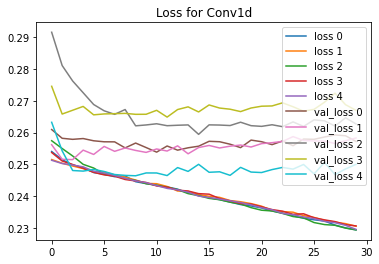

In [20]:
for i in tqdm(range(NFOLD)):
    loss = cnnv1D_result[i]['loss']
    plt.plot(loss, label = 'loss {}'.format(i))
    
for i in tqdm(range(NFOLD)):
    val_loss = cnnv1D_result[i]['val_loss']
    plt.plot(val_loss, label = 'val_loss {}'.format(i))
 
    
plt.legend(loc='upper right')
plt.title('Loss for Conv1d')
plt.savefig('Conv1D_Batch_Dropout_Aug_%d.png'%(FILTER_SIZE))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

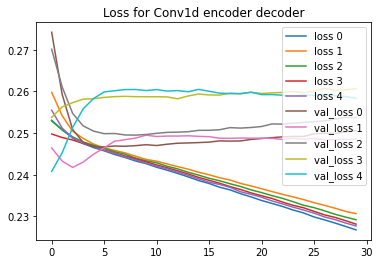

In [21]:
for i in tqdm(range(NFOLD)):
    loss = cnn1D_encoder_decoder_result[i]['loss']
    plt.plot(loss, label = 'loss {}'.format(i))
    

for i in tqdm(range(NFOLD)):
    val_loss = cnn1D_encoder_decoder_result[i]['val_loss']
    plt.plot(val_loss, label = 'val_loss {}'.format(i))
    

plt.legend(loc='upper right')
plt.title('Loss for Conv1d encoder decoder')
plt.savefig('Conv1D_Enc_Dec_Batch_Dropout_Aug_%d.png'%(FILTER_SIZE))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

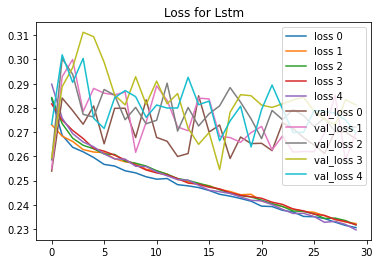

In [22]:
for i in tqdm(range(NFOLD)):
    loss = lstm_result[i]['loss']
    plt.plot(loss, label = 'loss {}'.format(i))
    

for i in tqdm(range(NFOLD)):
    val_loss = lstm_result[i]['val_loss']
    plt.plot(val_loss, label = 'val_loss {}'.format(i))
    

plt.legend(loc='upper right')
plt.title('Loss for Lstm')
plt.savefig('LSTM_Batch_Dropout_Aug_%d.png'%(FILTER_SIZE))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

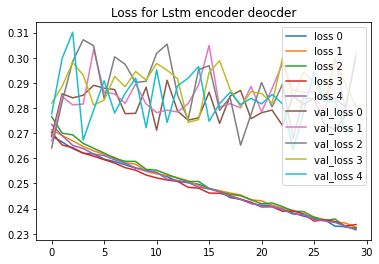

In [23]:
for i in tqdm(range(NFOLD)):
    loss = lstm_encoder_decoder_result[i]['loss']
    plt.plot(loss, label = 'loss {}'.format(i))
    

for i in tqdm(range(NFOLD)):
    val_loss = lstm_encoder_decoder_result[i]['val_loss']
    plt.plot(val_loss, label = 'val_loss {}'.format(i))
    

plt.legend(loc='upper right')
plt.title('Loss for Lstm encoder deocder')
plt.savefig('LSTM_Enc_Dec_Batch_Dropout_Aug_%d.png'%(FILTER_SIZE))

# Result and Prediction

In [24]:
def model_threshold_prediction(model_type):
    for i in tqdm(range(NFOLD)):
        train_dataset_1, val_dataset_1, test_dataset_1 = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i, model = 1)
        train_dataset_2, val_dataset_2, test_dataset_2 = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i, model = 2)
    
    a = 0
    conv_anomaly_label = {}
    for i in test_dataset_1:
        for t in i[1]:
            a+=1
            conv_anomaly_label[a] = int(t.numpy()[0])
    b = 0
    lstm_anomaly_label = {}
    for i in test_dataset_2:
        for t in i[1]:
            b+=1
            lstm_anomaly_label[b] = int(t.numpy()[0])
                
    if model_type == model_conv1d_enc_dec:
        model_predict = []
        prediction = model_type.predict(test_dataset_1, verbose = True)
        for i in range(len(prediction)):
            result = sum(prediction[i]) / len(prediction[i])
            model_predict.append(result)
            
        plt.subplot(2, 1, 1)
        plt.title("Conv1D Encoder Decoder Model Prediction")
        plt.plot(model_predict)
        plt.subplot(2, 1, 2)
        plt.hist(model_predict, bins='auto')
        plt.savefig('Conv1D Encoder Decoder Model Prediction_%d.png'%(FILTER_SIZE))
        
        Conv1D = pd.DataFrame(model_predict)
        Conv1D.columns = ['Result']
        anomaly = Conv1D['Result'] > np.percentile(Conv1D, 95)
                 
        con1d_tn, con1d_fp, con1d_fn, con1d_tp = confusion_matrix(list(conv_anomaly_label.values()), list(anomaly)).ravel()
        print("Conv1d confusion matrix:")
        print("tn:",con1d_tn ,"fp:" , con1d_fp,"fn:" , con1d_fn,"tp:", con1d_tp)   
        conv_accuracy = (con1d_tn + con1d_tp) / (con1d_tn  + con1d_fp + con1d_fn + con1d_fn)
        print(conv_accuracy)
        
    elif model_type == model_conv1d:
        prediction = model_type.predict(test_dataset_1, verbose = True)
        
        plt.subplot(2, 1, 1)
        plt.title("Conv1D Model Prediction")    
        plt.plot(prediction)
        plt.subplot(2, 1, 2)
        plt.hist(prediction, bins='auto')
        plt.savefig('Conv1D Model Prediction_%d.png'%(FILTER_SIZE))
        
        Conv1D_encode_decoder = pd.DataFrame(prediction)
        Conv1D_encode_decoder.columns = ['Result']
        anomaly = Conv1D_encode_decoder['Result'] > np.percentile(Conv1D_encode_decoder, 95)
                  
        con1d_enc_dec_tn, con1d_enc_dec_fp, con1d_enc_dec_fn, con1d_enc_dec_tp = confusion_matrix(list(conv_anomaly_label.values()), list(anomaly)).ravel()
        print("Conv1d_encoder_decoder confusion matrix:")
        print("tn:", con1d_enc_dec_tn, "fp:",  con1d_enc_dec_fp, "fn:", con1d_enc_dec_fn, "tp:", con1d_enc_dec_tp)
        conv_enc_dec_accuracy = (con1d_enc_dec_tn + con1d_enc_dec_tp) / (con1d_enc_dec_tn  + con1d_enc_dec_fp + con1d_enc_dec_fn + con1d_enc_dec_tp)
        print(conv_enc_dec_accuracy)
        
    elif model_type == model_lstm:
        prediction = model_type.predict(test_dataset_2, verbose = True)
        
        plt.subplot(2, 1, 1)
        plt.title("LSTM Model Prediction")    
        plt.plot(prediction)
        plt.subplot(2, 1, 2)
        plt.hist(prediction, bins='auto')
        plt.savefig('LSTM Model Prediction_%d.png'%(FILTER_SIZE))
        
        LSTM = pd.DataFrame(prediction)
        LSTM.columns = ['Result']
        anomaly = (LSTM['Result'] > np.percentile(LSTM, 95))
                    
        lstm_tn, lstm_fp, lstm_fn, lstm_tp = confusion_matrix(list(lstm_anomaly_label.values()), list(anomaly)).ravel()
        lstm_accuracy = (lstm_tn + lstm_tp) / (lstm_tn + lstm_fp + lstm_fn + lstm_tp)
        
        print("LSTM confusion matrix:")
        print("tn:",lstm_tn ,"fp:" , lstm_fp,"fn:" , lstm_fn,"tp:" , lstm_tp)
        print(lstm_accuracy)
    elif model_type == model_lstm_enc_dec:
        prediction = model_type.predict(test_dataset_2, verbose = True)
           
        plt.subplot(2, 1, 1)
        plt.title("LSTM Encoder Decoder Model Prediction")    
        plt.plot(prediction)
        plt.subplot(2, 1, 2)
        plt.hist(prediction, bins='auto')
        plt.savefig('LSTM Encoder Decoder Model Prediction_%d.png'%(FILTER_SIZE))
        
        LSTM_encoder_decoder = pd.DataFrame(prediction)
        LSTM_encoder_decoder.columns = ['Result']
        anomaly = (LSTM_encoder_decoder['Result'] > np.percentile(LSTM_encoder_decoder, 95))
                
        lstm_enc_dec_tn, lstm_enc_dec_fp, lstm_enc_dec_fn, lstm_enc_dec_tp = confusion_matrix(list(lstm_anomaly_label.values()), list(anomaly)).ravel()
        lstm_enc_dec_accuracy = (lstm_enc_dec_tn + lstm_enc_dec_tp) / (lstm_enc_dec_tn + lstm_enc_dec_fp + lstm_enc_dec_fn + lstm_enc_dec_tp)
        
        print("LSTM_encoder_decoder confusion matrix:")
        print("tn:", lstm_enc_dec_tn, "fp:",  lstm_enc_dec_fp, "fn:", lstm_enc_dec_fn, "tp:", lstm_enc_dec_tp)
        print(lstm_enc_dec_accuracy)

  0%|          | 0/5 [00:00<?, ?it/s]

13/13 [==============================] - 1s 38ms/step
Conv1d_encoder_decoder confusion matrix:
tn: 235 fp: 14 fn: 160 tp: 7
0.5817307692307693


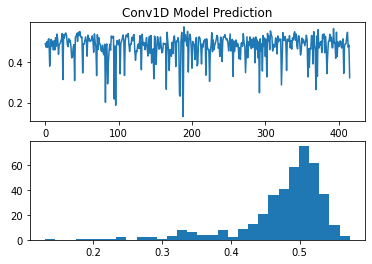

In [25]:
model_threshold_prediction(model_conv1d)

  0%|          | 0/5 [00:00<?, ?it/s]

13/13 [==============================] - 1s 43ms/step
Conv1d confusion matrix:
tn: 237 fp: 12 fn: 158 tp: 9
0.4353982300884956


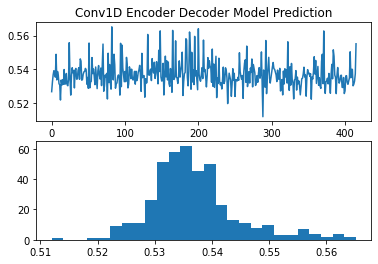

In [26]:
model_threshold_prediction(model_conv1d_enc_dec)

  0%|          | 0/5 [00:00<?, ?it/s]

13/13 [==============================] - 2s 15ms/step
LSTM confusion matrix:
tn: 235 fp: 14 fn: 160 tp: 7
0.5817307692307693


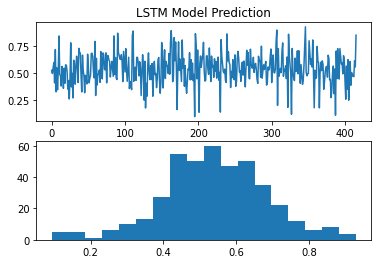

In [27]:
model_threshold_prediction(model_lstm)

  0%|          | 0/5 [00:00<?, ?it/s]

13/13 [==============================] - 4s 35ms/step
LSTM_encoder_decoder confusion matrix:
tn: 240 fp: 9 fn: 155 tp: 12
0.6057692307692307


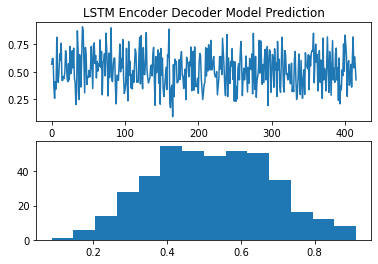

In [28]:
model_threshold_prediction(model_lstm_enc_dec)